In [1]:
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from analysis_utils import *
from scipy.stats import norm
import bayesfit as bf

os.chdir('../')
os.getcwd()

'/Users/sumiyaabdirashid/Desktop/PhD/code/git/PRF_Experiment_Checkers/Experiment'

Load data into Pandas dataframe. To be implemented: run some tests to ensure data quality

- does run exist? 
- does run contain responses?
- does run log color_balance and fix_intensity values correctly?

# Analysis of 2AFC Attn Task

In psychophysics task participants respond to each trial indicating whether the stimulus presented is more dark or more light.

### Scoring convention

**LARGE AF:** Response Left (color_balance < 0.5) = Dark; Response Right (color_balance > 0.5) = Light.

**SMALL AF:** Response Left (fix color < 0) = Dark; Response Right (fix color > 0) = Light

In [3]:
f_names

['/Users/sumiyaabdirashid/Desktop/PhD/code/git/PRF_Experiment_Checkers/Experiment/logs/psychophys/sub-003_0_psyc_3_l_Logs/sub-003_0_psyc_3_l_events.tsv',
 '/Users/sumiyaabdirashid/Desktop/PhD/code/git/PRF_Experiment_Checkers/Experiment/logs/psychophys/sub-003_0_psyc_3_s_Logs/sub-003_0_psyc_3_s_events.tsv']

In [2]:
wd = os.getcwd()
f_names = glob.glob(f"{wd}/logs/psychophys/*/sub-003*.tsv")
all_logs = load_data(f_names)
if 'large_prop' in all_logs.columns:
    all_logs.rename(columns = {'large_prop':'color_balance','small_prop':'fix_intensity'}, inplace = True) 
all_logs[all_logs.event_type == 'response'].head()
# all_logs.color_balance..value_counts()

,trial_nr,onset,event_type,phase,response,nr_frames,color_balance,fix_intensity,onset_abs,duration,end,end_abs,task,run
1,0,-68.999460,response,0,space,0.0,0.20,0.4,13.171379,0.0,-68.999460,13.171379,l,3
2,0,3.899319,response,1,right,0.0,0.20,0.4,86.070158,0.0,3.899319,86.070158,l,3
5,1,5.240091,response,1,left,0.0,0.80,0.4,87.410930,0.0,5.240091,87.410930,l,3
8,2,6.524334,response,1,left,0.0,0.15,0.4,88.695173,0.0,6.524334,88.695173,l,3
11,3,7.427075,response,1,right,0.0,0.90,0.1,89.597914,0.0,7.427075,89.597914,l,3


In [4]:
df = all_logs[(all_logs.event_type == 'response')]
# fixed = np.append(np.array(df.color_balance)[1:],[np.array(df.color_balance)[-1]])
# df.color_balance = fixed
df['correct_s'] = np.nan
df['correct_l'] = np.nan

# Color task
true_left_l = df[(df.color_balance < 0.5) & (df.response == 'left')].index
false_left_l = df[(df.color_balance > 0.5) & (df.response == 'left')].index

true_right_l = df[(df.color_balance > 0.5) & (df.response == 'right')].index
false_right_l = df[(df.color_balance < 0.5) & (df.response == 'right')].index

true_left_s = df[(df.fix_intensity < 0.5) & (df.response == 'left')].index
false_left_s = df[(df.fix_intensity > 0.5) & (df.response == 'left')].index

true_right_s = df[(df.fix_intensity > 0.5) & (df.response == 'right')].index
false_right_s = df[(df.fix_intensity < 0.5) & (df.response == 'right')].index

df.loc[np.hstack((true_left_l,true_right_l)), 'correct_l'] = 1
df.loc[np.hstack((false_left_l,false_right_l)), 'correct_l'] = 0

df.loc[np.hstack((true_left_s,true_right_s)), 'correct_s'] = 1
df.loc[np.hstack((false_left_s,false_right_s)), 'correct_s'] = 0

# df = df.dropna() # drop where color balance = 0.5
df.tail()

# print(f'Total response "right": {sum(df.response == "left")} \
#     \nTotal response "left": {sum(df.response == "right")} \
#     \ntrue_left: {len(true_left)/sum(df.fix_intensity < 0)} \
#     \ntrue_right: {len(true_right)/sum(df.fix_intensity > 0)} \
#     \nfalse_left: {len(false_left)/sum(df.fix_intensity < 0)} \
#     \nfalse_right: {len(false_right)/sum(df.fix_intensity > 0)}')

,trial_nr,onset,event_type,phase,response,nr_frames,color_balance,fix_intensity,onset_abs,duration,end,end_abs,task,run,correct_s,correct_l
1337,220,251.967847,response,1,right,0.0,0.40,0.50,267.971196,0.0,251.967847,267.971196,s,3,NaN,0.0
1340,221,254.087301,response,1,left,0.0,0.15,0.70,270.090650,0.0,254.087301,270.090650,s,3,0.0,1.0
1343,222,255.860898,response,1,left,0.0,0.50,0.30,271.864247,0.0,255.860898,271.864247,s,3,1.0,NaN
1346,223,256.834163,response,1,left,0.0,0.50,0.40,272.837512,0.0,256.834163,272.837512,s,3,1.0,NaN
1349,224,257.902478,response,1,right,0.0,0.60,0.85,273.905827,0.0,257.902478,273.905827,s,3,1.0,1.0


Plot response light v.s. proportion light. Should increase together

### Plot large AF

Diff: 0.1      	 n_correct: 29      	n_trials: 40     	% correct 72.5
Diff: 0.15      	 n_correct: 35      	n_trials: 40     	% correct 87.5
Diff: 0.2      	 n_correct: 28      	n_trials: 40     	% correct 70.0
Diff: 0.3      	 n_correct: 29      	n_trials: 40     	% correct 72.5
Diff: 0.4      	 n_correct: 20      	n_trials: 40     	% correct 50.0
Diff: 0.6      	 n_correct: 27      	n_trials: 40     	% correct 67.5
Diff: 0.7      	 n_correct: 26      	n_trials: 40     	% correct 65.0
Diff: 0.8      	 n_correct: 30      	n_trials: 40     	% correct 75.0
Diff: 0.85      	 n_correct: 27      	n_trials: 40     	% correct 67.5
Diff: 0.9      	 n_correct: 31      	n_trials: 40     	% correct 77.5


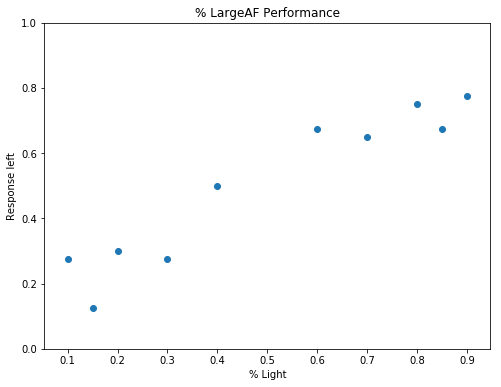

In [7]:
df_l = df[(df.run == '3')]
df_l =  df_l.dropna(subset=['correct_l']) # drop where color balance = 0.5
difficulties_l = sorted(df_l.color_balance.unique())
n_correct_l = []
n_trials_l = []
resp_light_l = []

for diff in difficulties_l:
    print(f'Diff: {diff}  \
    \t n_correct: {len(df_l[(df_l.color_balance == diff) & (df_l.correct_l == 1)])}  \
    \tn_trials: {len(df_l[df_l.color_balance == diff])} \
    \t% correct {100*len(df_l[(df_l.color_balance == diff) & (df_l.correct_l == 1)])/len(df_l[df_l.color_balance == diff]):.1f}')
    n_correct_l.append(len(df_l[(df_l.color_balance == diff) & (df_l.correct_l == 1)]))
    n_trials_l.append(len(df_l[df_l.color_balance == diff]))
#     print(f'% Light: {diff}, \t% Response Light {round(len(df[(df.color_balance == diff) & (df.response == "right")]) / len(df[df.color_balance == diff]) *100,1)}')
    resp_light_l.append(len(df_l[(df_l.color_balance == diff) & (df_l.response == "right")]) / len(df_l[df_l.color_balance == diff]))

proportions_l = np.array(n_correct_l) / np.array(n_trials_l)

largeAFx, largeAFy = abs(np.array(difficulties_l)-0.5), proportions_l
          
fig, axs = plt.subplots(1,1, figsize=(8,6))

axs.set_title('% LargeAF Performance')
axs.set_ylabel('Response left')
axs.set_ylim(0,1)
axs.set_xlabel('% Light')
axs.scatter(difficulties_l,resp_light_l)

### Plot small AF

,diff,n_trials,resp_light,n_correct,percent_correct
0,0.10,40.0,0.225,31.0,77.5
1,0.15,40.0,0.275,29.0,72.5
2,0.20,40.0,0.200,32.0,80.0
3,0.30,40.0,0.425,23.0,57.5
4,0.40,40.0,0.400,24.0,60.0
5,0.60,40.0,0.700,28.0,70.0
6,0.70,40.0,0.725,29.0,72.5
7,0.80,40.0,0.750,30.0,75.0
8,0.85,40.0,0.800,32.0,80.0
9,0.90,40.0,0.675,27.0,67.5


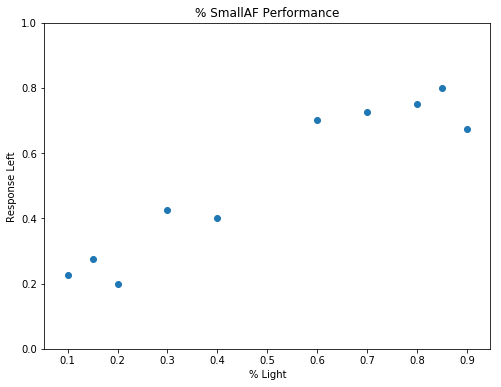

In [9]:
df_s = df[(df.run == '3')]
df_s =  df_s.dropna(subset=['correct_s']) # drop where fix color = 0
difficulties_s = sorted(df_s.fix_intensity.unique())
summary = pd.DataFrame([])
n_correct_s = []
n_trials_s = []
resp_light_s = []

for idx, diff in enumerate(difficulties_s):
    
    summary.loc[idx,'diff'] = diff
    summary.loc[idx,'n_trials'] = len(df_s[df_s.fix_intensity == diff])
    summary.loc[idx,'resp_light'] = len(df_s[(df_s.fix_intensity == diff) & (df_s.response == "right")]) / len(df_s[df_s.fix_intensity == diff])
    summary.loc[idx,'n_correct'] = len(df_s[(df_s.fix_intensity == diff) & (df_s.correct_s == 1)])
    summary.loc[idx,'percent_correct'] = 100*len(df_s[(df_s.fix_intensity == diff) & (df_s.correct_s == 1)])/len(df_s[df_s.fix_intensity == diff])
    summary.head()

    n_correct_s.append(len(df_s[(df_s.fix_intensity == diff) & (df_s.correct_s == 1)])) 
    n_trials_s.append(len(df_s[df_s.fix_intensity == diff]))
#     print(f'% Light: {diff}, \t% Response Light {round(len(df[(df.fix_intensity == diff) & (df.response == "right")]) / len(df[df.fix_intensity == diff]) *100,1)}')
    resp_light_s.append(len(df_s[(df_s.fix_intensity == diff) & (df_s.response == "right")]) / len(df_s[df_s.fix_intensity == diff]))

proportions_s = np.array(n_correct_s) / np.array(n_trials_s)

smallAFx, smallAFy = abs(np.array(difficulties_s)), proportions_s

fig, axs = plt.subplots(1,1, figsize=(8,6))

axs.set_title('% SmallAF Performance')
axs.set_ylim(0,1)
axs.set_ylabel('Response Left')
axs.set_xlabel('% Light')
axs.scatter(difficulties_s,resp_light_s)

summary

## Plot difficulty v.s. proportion correct

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(12,4))

axs[0].set_title('SmallAF')
axs[0].set_ylabel('Proportion Correct')
axs[0].set_ylim(0,1)
axs[0].set_xlabel('% Light')
axs[0].scatter(smallAFx, smallAFy)

axs[1].set_title('LargeAF')
axs[1].set_ylabel('Proportion Correct')
axs[1].set_ylim(0,1)
axs[1].set_xlabel('Distance from 50%')
axs[1].scatter(largeAFx, largeAFy)

# Fitting a sigmoid function to data

In [ ]:
nr = np.random.weibull(10,int(1e4))
plt.figure
plt.hist(nr,density=True,bins=50)
plt.show

p(x) = \frac{a} {\lambda}(\frac{x}{\lambda})^{a-1}e^{-(x/\lambda)^a},

3.287638363558054
20%: 0.08       
80%: 0.92


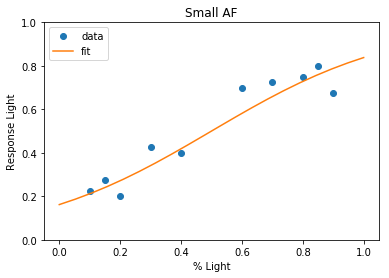

3.26435272040879
20%: 0.08       
80%: 0.76


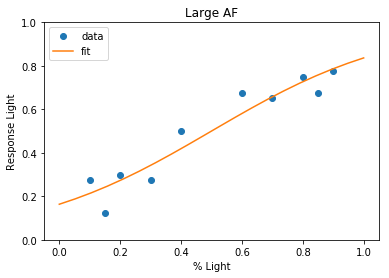

In [14]:
#use weibull instead????

# def F(a,b):
#     1- np.exp()

# def weibull(g,l,a,b):
#     y = g +(1-g -l)*F(a,b)
#     return y

def sigmoid(x, x0, k):
    y = 1 / (1 + np.exp(-k*(x-0.5)))
    return y

def inv_sigmoid(y,x0,k):
    return x0 - (np.log((1/y)-1)/k)

## SMALL AF ##
xdata = difficulties_s
ydata = resp_light_s

popt, pcov = curve_fit(sigmoid, xdata, ydata)
print(*popt)
print(f'20%: {inv_sigmoid(.2,*popt):.2f} \
      \n80%: {inv_sigmoid(.80,*popt):.2f}')

x = np.linspace(0, 1, 20)
y = sigmoid(x, *popt)

plt.plot(xdata, ydata, 'o', label='data')
plt.title('Small AF')
plt.plot(x,y, label='fit')
plt.ylim(0, 1)
plt.ylabel('Response Light')
plt.xlabel('% Light')
plt.legend(loc='best')
plt.show()

## LARGE AF ##
xdata = difficulties_l
ydata = resp_light_l

popt, pcov = curve_fit(sigmoid, xdata, ydata)
print(*popt)
print(f'20%: {inv_sigmoid(.2,*popt):.2f} \
      \n80%: {inv_sigmoid(.7,*popt):.2f}')

x = np.linspace(0, 1, 20)
y = sigmoid(x, *popt)

plt.plot(xdata, ydata, 'o', label='data')
plt.title('Large AF')
plt.plot(x,y, label='fit')
plt.ylim(0, 1)
plt.ylabel('Response Light')
plt.xlabel('% Light')
plt.legend(loc='best')
plt.show()

# Testing BayesFit

Organize data into `[M X 3 ndarray]` where n is the number of stimulus intensities and the columns are: `[stimulus intensity, N trials correct, and N trials total]`.

In [ ]:
data_s = np.vstack((difficulties_s,n_correct_s, n_trials_s)).T

# metrics, options = bf.fitmodel(data_s, nafc = 2)

# Analysis of Attn PRF Detection Task

In [ ]:
wd = os.getcwd()
f_names = glob.glob(f"{wd}/logs/*/sub-002*.tsv")
all_logs = load_data(f_names)
if 'large_prop' in all_logs.columns:
    all_logs.rename(columns = {'large_prop':'color_balance','small_prop':'fix_intensity'}, inplace = True) 
all_logs.head()

Calculate correct and incorrect responses. Use this to get hits (true positives), misses (false negatives), false alarms (false positives) and correct rejections (true negatives). Once we have these values we can calculate d' and the criterion (c). 

### Summary per run

In [ ]:
psyc, d_primes, large_cor, small_cor = analyse_logs(all_logs)
psyc

We can also calculate d' per difficulty level and plot this to see if two task difficulties are comparable. Unfortunately d' can go to infinity so many points are missing from the performance curves... and we're unsure if they're sigmoidal.

In [ ]:
Z = norm.ppf
d_primes['d_prime']= Z(d_primes['hit_rate'])- Z(d_primes['fa_rate'])
d_primes['criterion'] = -(Z(d_primes['hit_rate']) + Z(d_primes['fa_rate'])) / 2
d_primes.head()

In [ ]:
large_AF = d_primes[d_primes['run'].astype(int) % 2 == 1]
small_AF = d_primes[d_primes['run'].astype(int) % 2 == 0]

In [ ]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.set_title('SmallAF')
ax1.scatter(abs(small_AF['difficulty']),small_AF['d_prime'])
ax1.set_ylabel('Dprime')

ax2.set_title('LargeAF')
ax2.scatter(abs(large_AF['difficulty']-0.5),large_AF['d_prime'],color='orange')
ax2.set_ylabel('Dprime')

We can also use proportion correct to create psychometric curves - although these are not traditional sigmoidal psychometric curves which are designed for 2 alternative forced-choice (2AFC) task. 

In [ ]:
largex, largey = (np.array([i[0] for i in large_cor]), 
                  np.array([i[1] for i in large_cor]))
smallx,smally = (np.array([i[0] for i in small_cor]), 
                np.array([i[1] for i in small_cor]))

In [ ]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(12,8))

ax1.set_title('LargeAF_Sigmoid')
ax1.scatter([abs(i[0]-0.5) for i in large_cor], [i[1] for i in large_cor])
ax1.set_ylabel('Proportion Correct')

ax2.set_title('LargeAF_Gauss')
ax2.scatter([i[0] for i in large_cor], [i[1] for i in large_cor])
ax2.set_ylabel('Proportion Correct')

ax3.set_title('SmallAF_Sigmoid')
ax3.set_ylim(0,1)
ax3.scatter([abs(i[0]-0) for i in small_cor], [i[1] for i in small_cor], color='orange')

ax4.set_title('SmallAF_Gauss')
ax4.set_ylim(0,1)
ax4.scatter([i[0] for i in small_cor], [i[1] for i in small_cor], color='orange')

# Modeling psychometric curve

In [ ]:
def psyc_stim_list(stim_range, n_stim, baseline):
    " Creates stim list for psychophysics task"
    stim_list = stim_range*int(n_stim/len(stim_range))
    [stim_list.append(i) for i in [baseline]*(n_stim-len(stim_list))]
    np.random.shuffle(stim_list)
    return stim_list

range = [0.1, 0.15, 0.2, 0.3, 0.4 ,0.5, 0.6, 0.7, 0.8, 0.85,0.9]
n = 225


stim = psyc_stim_list(range,n, 0.5)

for v in set(stim):
    c=0
    print(f'{v}: {sum([c +1 if v == stim[i] else c for i,j in enumerate(stim)])}')

In [ ]:
def model_pr():
    '''
    return array of probabilities corresponding to GAUSSIAN cdf
    stimuli is range of color_balances / fix intensities
    loc
    sd / scale
    '''
    
    stim_x = np.arange(0,0.6,0.05)
    mu = 0.3
    sd = 0.1
    
    model_pr = norm.cdf(stim_x, mu,sd)
    
    return stim_x, model_pr

In [ ]:
x,pr = model_pr()
plt.plot(x, pr, color='k', marker='x', lw=2, ls='--')
plt.xlim(0,0.6)
plt.ylim(0,1)
plt.show()